In [1]:
import sympy
from sympy.physics.quantum import TensorProduct as tensor
from sympy import pi, I
from IPython.display import display, Math, Latex
import itertools
import numpy as np

In [2]:
sympy.init_printing()

In [3]:
ket = {}
for i in range(2):
    name = str(i)
    ket[name] = sympy.zeros(2,1)
    ket[name][i] = 1
for i in range(2):
    for j in range(2):
        name = str(i) + str(j)
        ket[name] = tensor(ket[str(i)], ket[str(j)])

In [4]:
def ketbra(i, j):
    return ket[i] * ket[j].H

In [5]:
rho = {}
for i in ['00', '01', '10', '11']:
    rho[i] = {}
    for j in ['00', '01', '10', '11']:
        rho[i][j] = ketbra(i, j)

In [6]:
def evaluate_lindblad(rho):
    As = [ketbra('00', '10') + ketbra('01', '11'), ketbra('00', '01') + ketbra('10', '11')]
    result = sympy.zeros(4)
    for i, A in enumerate(As):
        gamma = sympy.symbols('gamma_%d' % (i+1), real=True)
        result += gamma * (A*rho*A.H - (A.H*A*rho + rho*A.H*A)/2)
    return result

In [7]:
def construct_superop():
    result = []
    L = sympy.zeros(16)
    for col, (i, j) in enumerate(itertools.product(['00', '01', '10', '11'], ['00', '01', '10', '11'])):
        L_rho = evaluate_lindblad(rho[i][j])
        L_rho_vec = L_rho.conjugate().reshape(16,1)
        for row in range(16):
            L[row, col] = L_rho_vec[row]
    return L
        

In [8]:
L = construct_superop()

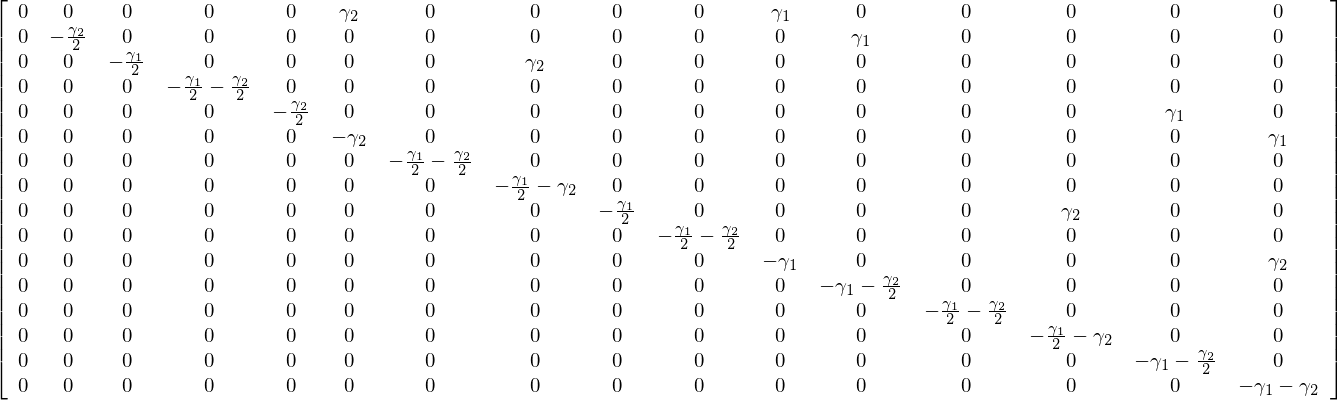

In [9]:
L

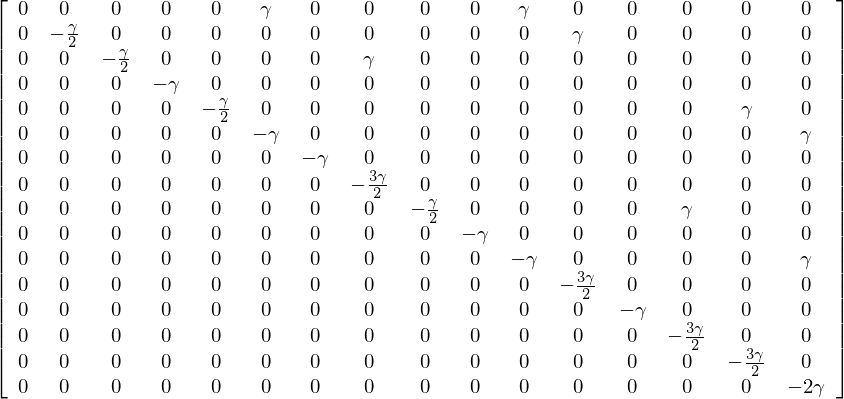

In [10]:
gamma1 = sympy.symbols('gamma_1', real=True)
gamma2 = sympy.symbols('gamma_2', real=True)
gamma = sympy.symbols('gamma', real=True)
L2 = L.subs({gamma1: gamma, gamma2: gamma})
L2

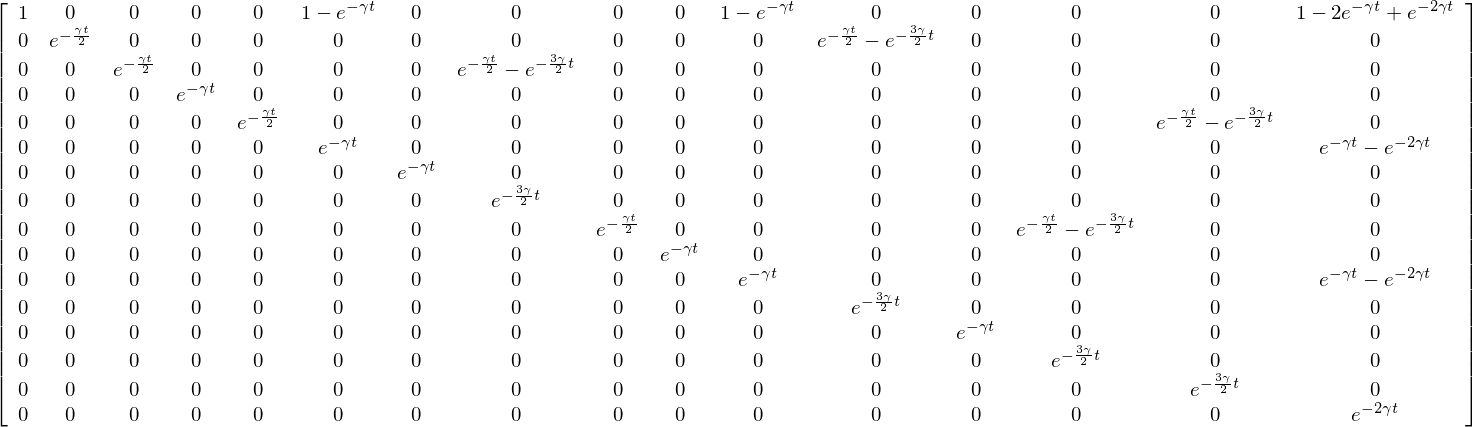

In [11]:
t = sympy.symbols('t', real=True)
Epsilon = (L2*t).exp(); # time evolution superoperator
Epsilon

In [12]:
def DynMap(rho):
    rho_vec = rho.conjugate().reshape(16,1)
    return (Epsilon*rho_vec).reshape(4,4).conjugate()

In [13]:
def construct_Favg():
    result = None
    for i in ['00', '01', '10', '11']:
        for j in ['00', '01', '10', '11']:
            term =   ket[i].H * DynMap(rho[i][j]) * ket[j] \
                   + ket[i].H * DynMap(rho[j][j]) * ket[i]
            if result is None:
                result = term
            else:
                result += term
    return (result / 20)[0,0]

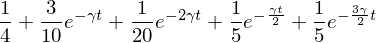

In [14]:
Favg = construct_Favg();
Favg

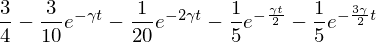

In [15]:
1-Favg

In [16]:
def Err(gamma, t):
    """Evaluate gate error for gamma in MHz and t in ns"""
    gamma_sym, t_sym = sympy.symbols('gamma, t', real=True) 
    fun = sympy.lambdify((gamma_sym, t_sym), Favg)
    return 1-fun(1e-3*2*np.pi*gamma, t)

In [17]:
import matplotlib.pylab as plt

In [22]:
%matplotlib inline

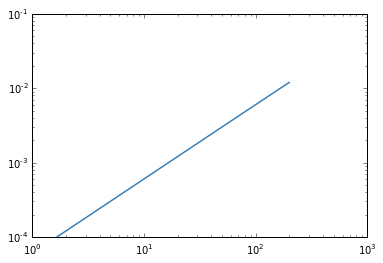

In [23]:
tgrid = np.linspace(0, 200, 100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tgrid, [Err(1.2e-2, t) for t in tgrid])
ax.set_yscale('log')
ax.set_xscale('log')

In [20]:
import pandas as pd

In [30]:
gate_times = [5, 10, 20, 50, 100, 200] # ns
df = pd.DataFrame(index=gate_times,
     data={'minimum error': [Err(1.2e-2, t=t) for t in gate_times]})
df.index.name = "gate duration [ns]"
print df.to_string(float_format=lambda f:'%.2e'%f)

                    minimum error
gate duration [ns]               
5                        3.02e-04
10                       6.03e-04
20                       1.21e-03
50                       3.01e-03
100                      6.00e-03
200                      1.20e-02


In [31]:
gate_times = [5, 10, 20, 50, 100, 200] # ns
df = pd.DataFrame(index=gate_times,
     data={'minimum error': [Err(1.2e-3, t=t) for t in gate_times]})
df.index.name = "gate duration [ns]"
print df.to_string(float_format=lambda f:'%.2e'%f)

                    minimum error
gate duration [ns]               
5                        3.02e-05
10                       6.03e-05
20                       1.21e-04
50                       3.02e-04
100                      6.03e-04
200                      1.21e-03
